In [ ]:
#default_exp data.datasets.business

# Business datasets

> API details.

In [ ]:
#export
import os
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
import s3fs
from dotenv import load_dotenv

from nixtla.data.datasets.utils import download_file, Info, TimeSeriesDataclass
from nixtla.data.tsdataset import TimeSeriesDataset

In [ ]:
#export
load_dotenv()

True

Tourism meta information

In [ ]:
#export
@dataclass
class BRC:
    seasonality: int = 7
    horizon: int = 7

@dataclass
class GLB:
    seasonality: int = 7
    horizon: int = 7

In [ ]:
#export
BusinessInfo = Info(groups=('BRC', 'GLB'),
                    class_groups=(BRC, GLB))

In [ ]:
#export
class Business(TimeSeriesDataclass):

    @staticmethod
    def load(directory: str,
             group: str,
             return_tensor: bool = True,
             return_weekly: bool = False) -> Tuple[pd.DataFrame, 
                                                   Optional[pd.DataFrame], 
                                                   Optional[pd.DataFrame]]:
        """
        Downloads and loads Tourism data.

        Parameters
        ----------
        directory: str
            Directory where data will be downloaded.
        group: str
            Group name.
            Allowed groups: 'D1', 'D2'.
            
        Notes
        -----
        [1] Returns train+test sets.
        """
        path = Path(directory) / 'business' / 'datasets'

        Business.download(directory, group)

        df = pd.read_csv(path / f'ts-{group.lower()}.csv')
        df['ds'] = pd.to_datetime(df['ds'])
        
        if return_weekly:
            df = df.groupby(['unique_id', pd.Grouper(key='ds', freq='W-THU')]) \
                   .sum() \
                   .reset_index()
            
        return df, None, None

    @staticmethod
    def download(directory: str, group: str) -> None:
        """Downloads Business Dataset."""
        
        fs = s3fs.S3FileSystem(key=os.environ['AWS_ACCES_KEY_ID'], 
                               secret=os.environ['AWS_SECRET_ACCESS_KEY'])

        path = Path(directory) / 'business' / 'datasets'
        download_file = path / f'ts-{group.lower()}.csv'
        if not download_file.exists():
            file = f'research-storage-orax/business-data/ts-{group.lower()}.csv'
            fs.download(file, str(download_file))

In [ ]:
for group in BusinessInfo.groups:
    print(group)
    dataset, *_ = Business.load(directory='data', group=group)
    print(dataset.head())

BRC
            unique_id         ds     y
0  uid_12601_2_124692 2018-01-02  66.0
1  uid_12601_2_124692 2018-01-03  70.0
2  uid_12601_2_124692 2018-01-04  53.0
3  uid_12601_2_124692 2018-01-05  52.0
4  uid_12601_2_124692 2018-01-06  45.0
GLB
         unique_id         ds     y
0  uid_3002_122693 2018-01-01   1.0
1  uid_3002_122693 2018-01-02  16.0
2  uid_3002_122693 2018-01-03  14.0
3  uid_3002_122693 2018-01-04  12.0
4  uid_3002_122693 2018-01-05   4.0


In [ ]:
d1, *_ = Business.load(directory='data', group='BRC', return_weekly=False)
d2, *_ = Business.load(directory='data', group='GLB', return_weekly=False)

<AxesSubplot:xlabel='ds'>

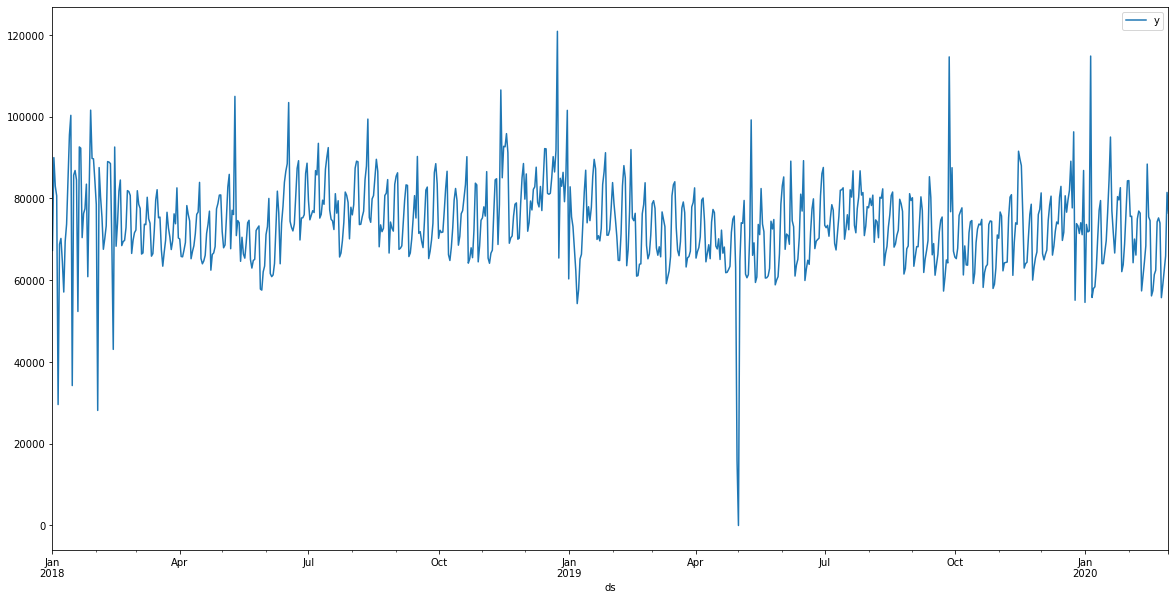

In [ ]:
d2.groupby('ds').sum().plot(figsize=(20, 10))

<AxesSubplot:xlabel='ds'>

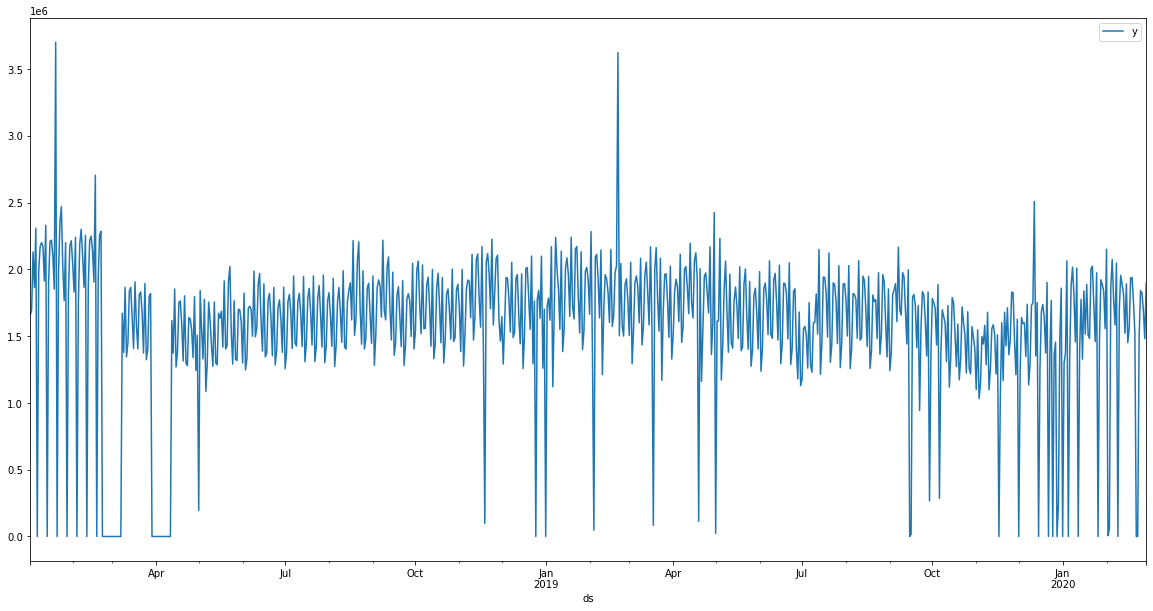

In [ ]:
d1.groupby('ds').sum().plot(figsize=(20, 10))